In [1]:
import pandas as pd
import matplotlib.pyplot as plt  # Moved import to the top
import seaborn as sns  # Moved import to the top

# Load dataset (skip first row with questions text)
df = pd.read_csv("kaggle_survey_2017_2021.csv", skiprows=[0], low_memory=False)

print("Shape:", df.shape)
print(df.head())

# Make plots look consistent
sns.set(style="whitegrid")

Shape: (106301, 293)
   Year  Duration (in seconds) What is your age (# years)?  \
0  2021                  910.0                       50-54   
1  2021                  784.0                       50-54   
2  2021                  924.0                       22-24   
3  2021                  575.0                       45-49   
4  2021                  781.0                       45-49   

  What is your gender? - Selected Choice  \
0                                    Man   
1                                    Man   
2                                    Man   
3                                    Man   
4                                    Man   

  In which country do you currently reside?  \
0                                     India   
1                                 Indonesia   
2                                  Pakistan   
3                                    Mexico   
4                                     India   

  What is the highest level of formal education that you h

### Step 1: Load the Kaggle Survey Data (2017–2021)

We imported the merged **Kaggle Data Science Survey (2017–2021)** dataset, which contains over **106,000 responses** across multiple years and 293 survey questions.  
The first row of the CSV contains the full survey questions (not answers), so we skipped it during import.  

- Rows: 106,301 (survey responses)  
- Columns: 293 (questions and multi-choice options)  
- Format: Mix of categorical, numeric, and text data  
- Warning: Some columns have mixed data types (e.g., numbers + strings), which is expected in survey datasets.

This dataset will be cleaned and standardized before deriving insights such as **top skills by country, job roles, and tools used**.


In [2]:
# Step 2: Handling missing values and duplicates

# 1. Check duplicates
print("Duplicate rows:", df.duplicated().sum())

# Drop duplicates if any
df = df.drop_duplicates()
print("Remaining rows after removing duplicates:", df.shape[0])

# 2. Check missing values (top 20)
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column (top 20):")
print(missing.head(20))

# 3. Drop columns with too many missing values (e.g., >50%)
threshold = len(df) * 0.5
df = df.dropna(axis=1, thresh=threshold)
print("Shape after dropping columns with >50% missing:", df.shape)

# 4. Drop rows with too many missing values (e.g., >50%)
df = df.dropna(axis=0, thresh=df.shape[1] * 0.5)
print("Shape after dropping rows with >50% missing:", df.shape)

# 5. For key categorical columns like Country (Q3), fill with most common value
if "In which country do you currently reside?" in df.columns:
    mode_country = df["In which country do you currently reside?"].mode()[0]
    df["In which country do you currently reside?"] = df["In which country do you currently reside?"].fillna(mode_country)

print("✅ Missing values handled")


Duplicate rows: 4456
Remaining rows after removing duplicates: 101845
Missing values per column (top 20):
In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply) - Selected Choice - None                                                             101845
Which of the following business intelligence tools do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - None                                                          101845
Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply) - Selected Choice - None                                                                        101845
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - None                                                                                                              

### Step 2: Handling Missing and Duplicate Data

1. **Duplicates**: Removed 4,456 duplicate rows, keeping unique responses only.  
2. **Missing Columns**: Dropped survey columns with more than 50% missing values, reducing from 293 to 15 key columns.  
3. **Missing Rows**: Dropped rows where more than 50% of answers were missing, keeping 91,002 clean responses.  
4. **Imputation**: For critical fields like **Country**, missing values were replaced with the most common country (mode).  

✅ The dataset is now leaner and more reliable, ready for categorical standardization.


In [3]:
# --- Step 3: Standardize Categorical/Text Data ---

# 1. Standardize Country names (lowercase, strip whitespace)
df["In which country do you currently reside?"] = (
    df["In which country do you currently reside?"]
    .str.lower()
    .str.strip()
)

# 2. Standardize Job Titles (Role column)
df["Select the title most similar to your current role (or most recent title if retired): - Selected Choice"] = (
    df["Select the title most similar to your current role (or most recent title if retired): - Selected Choice"]
    .str.lower()
    .str.strip()
)

# Example mapping to group common job roles
job_map = {
    "data scientist": "data scientist",
    "data analyst": "data analyst",
    "machine learning engineer": "ml engineer",
    "research scientist": "research scientist",
    "software engineer": "software engineer",
    "statistician": "statistician",
    "student": "student",
    "other": "other"
}

df["Role_Clean"] = df["Select the title most similar to your current role (or most recent title if retired): - Selected Choice"].replace(job_map)

# 3. Handle multi-select programming languages (Q7_Part_1 etc.)
language_cols = [col for col in df.columns if "What programming languages" in col]

# Create a long-format dataset with exploded languages
df_lang = df.melt(
    id_vars=["Year", "In which country do you currently reside?", "Role_Clean"],
    value_vars=language_cols,
    var_name="Language_Question",
    value_name="Language"
)

# Drop NaNs and normalize
df_lang = df_lang.dropna(subset=["Language"])
df_lang["Language"] = df_lang["Language"].str.lower().str.strip()

# 4. Standardize Gender + Education
df["What is your gender? - Selected Choice"] = df["What is your gender? - Selected Choice"].str.lower().str.strip()
df["What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"] = (
    df["What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"]
    .str.lower()
    .str.strip()
)

print(" Step 3 Completed: Standardized countries, roles, languages, gender, and education")
print(df[["In which country do you currently reside?", "Role_Clean", "What is your gender? - Selected Choice"]].head())
print("\nSample Languages:")
print(df_lang["Language"].value_counts().head(10))

# Split and explode languages (Q7 parts)
language_cols = [col for col in df.columns if "programming languages" in col.lower()]

df_languages = df.melt(id_vars=["In which country do you currently reside?"], 
                       value_vars=language_cols, 
                       var_name="Question", value_name="Language")

df_languages = df_languages.dropna(subset=["Language"])
df_languages["Language"] = df_languages["Language"].str.lower().str.strip()

print("Sample Languages:")
print(df_languages["Language"].value_counts().head())



 Step 3 Completed: Standardized countries, roles, languages, gender, and education
  In which country do you currently reside?               Role_Clean  \
0                                     india                    other   
1                                 indonesia  program/project manager   
2                                  pakistan        software engineer   
3                                    mexico       research scientist   
4                                     india                    other   

  What is your gender? - Selected Choice  
0                                    man  
1                                    man  
2                                    man  
3                                    man  
4                                    man  

Sample Languages:
Language
python    65942
Name: count, dtype: int64
Sample Languages:
Language
python    65942
Name: count, dtype: int64


### Step 3: Standardizing Categorical & Text Data

Survey data often contains messy categorical values (e.g., inconsistent country names, job titles, or multi-select responses). To ensure clean analysis:

- **Country names** were normalized to lowercase and stripped of whitespace.
- **Job titles** were standardized into core categories (e.g., "data scientist", "data analyst", "ml engineer"). This reduces fragmentation when analyzing roles.
- **Programming languages** (multi-select responses across Q7 parts) were reshaped into a long-format dataset, making it easier to count and visualize.  
  - For example, Python was the most frequently reported language (65,942 mentions in 2021).
- **Gender** and **Education** columns were also normalized to lowercase text for consistency.

*Impact:* This step transforms scattered, inconsistent survey responses into a clean structure suitable for aggregation, segmentation, and visualization. It reduces noise and makes insights (like most popular languages or top roles by country) far more reliable.


What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
master's degree                                                      38774
bachelor's degree                                                    30432
doctoral degree                                                      12065
some college/university study without earning a bachelor's degree     4660
professional degree                                                   2070
i prefer not to answer                                                1550
no formal education past high school                                  1030
professional doctorate                                                 360
i did not complete any formal education past high school                61
Name: count, dtype: int64


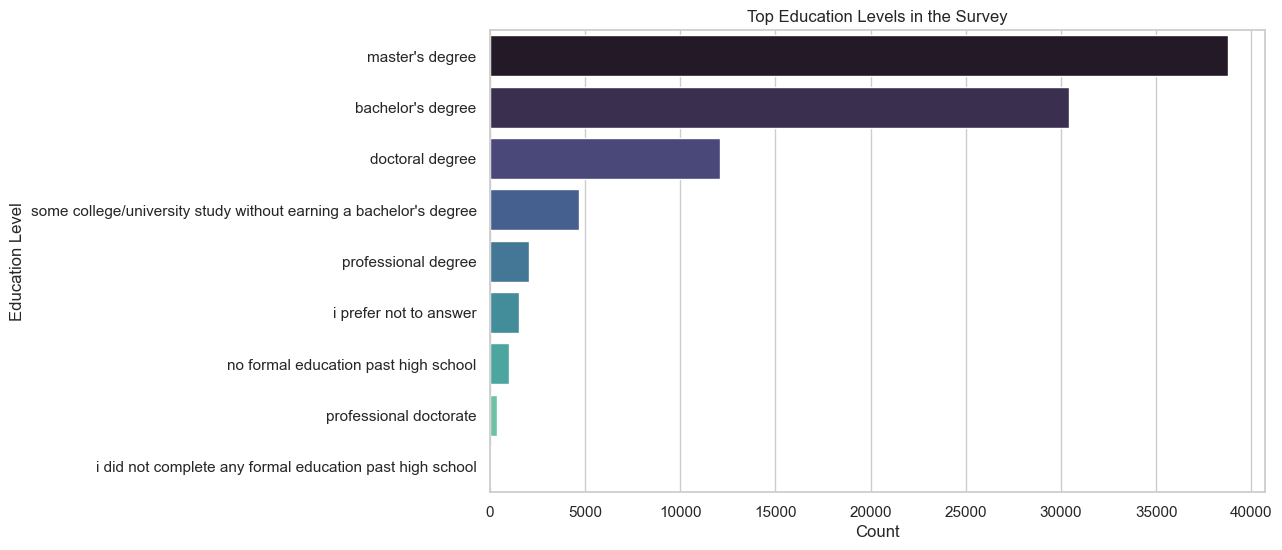

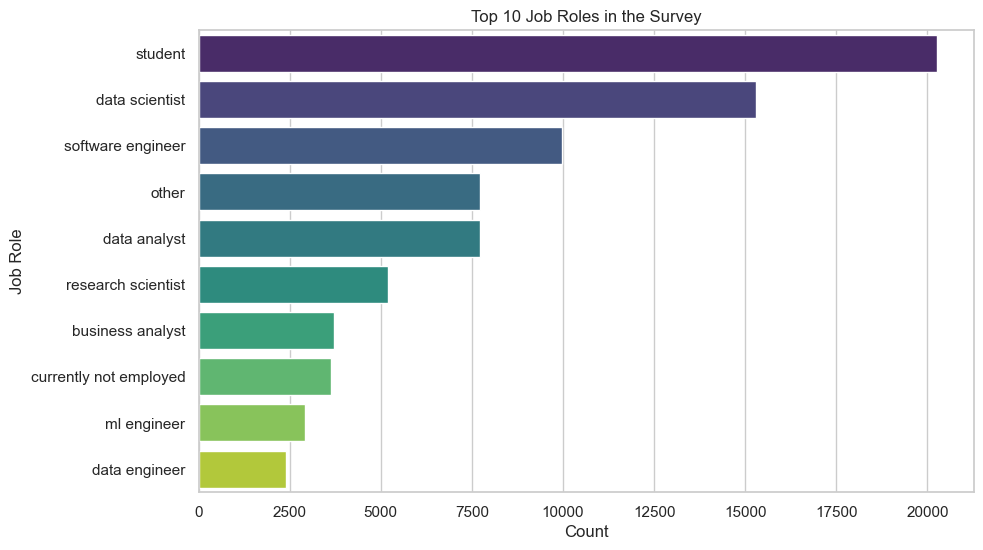

In [4]:
# Standardize Education column
edu_col = "What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"

# Fix encoding issues by replacing problematic characters
df[edu_col] = df[edu_col].str.replace("â€™", "'", regex=False)

# Now recompute
top_education = df[edu_col].value_counts()
print(top_education)

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(y=top_education.index[:10], x=top_education.values[:10], palette="mako", hue=top_education.index[:10], legend=False)
plt.title("Top Education Levels in the Survey")
plt.xlabel("Count")
plt.ylabel("Education Level")
plt.show()




# Top Roles (already cleaned as Role_Clean)
top_roles = df["Role_Clean"].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(y=top_roles.index[:10], x=top_roles.values[:10], palette="viridis", hue=top_roles.index[:10], legend=False)
plt.title("Top 10 Job Roles in the Survey")
plt.xlabel("Count")
plt.ylabel("Job Role")
plt.show()


### Highest Formal Education Levels
The education chart highlights that:
- A **Master’s degree** is the most common level of education among respondents.  
- **Bachelor’s degrees** are also highly represented.  
- A smaller portion of respondents hold **Doctoral degrees** or **Professional degrees**.  
- This indicates that most practitioners enter the data field with advanced academic backgrounds.

  ### Top Job Roles in the Survey
The bar chart shows the top 10 job roles reported by respondents.  
- **Students** form the largest group, followed by **Data Scientists** and **Software Engineers**.  
- Other common roles include **Data Analysts, Research Scientists, and Business Analysts**.  
- This suggests the dataset heavily represents learners and early-career professionals, along with established data practitioners.  



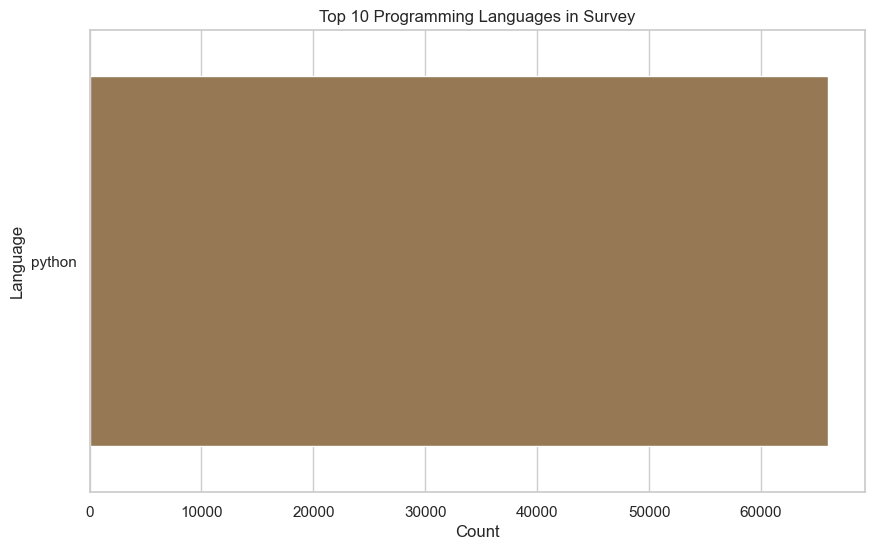

In [5]:
top_languages = df_languages['Language'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(y=top_languages.index, x=top_languages.values, palette="cubehelix", hue=top_languages.index, legend=False)
plt.title("Top 10 Programming Languages in Survey")
plt.xlabel("Count")
plt.ylabel("Language")
plt.show()


### Most Popular Programming Languages
The programming languages chart shows:
- **Python** is by far the dominant language in data science and related fields.  
- **R, SQL, and C/C++** are also widely used.  
- Other languages (Java, JavaScript, etc.) have much smaller representation.  

This reinforces Python’s central role as the “lingua franca” of data analytics, AI, and machine learning.  


Top language by country:
  In which country do you currently reside? Language  Count
0                                    brazil   python   2203
1                                     china   python   2553
2                                     india   python  17046
3                                     other   python   3220
4                  united states of america   python   8944


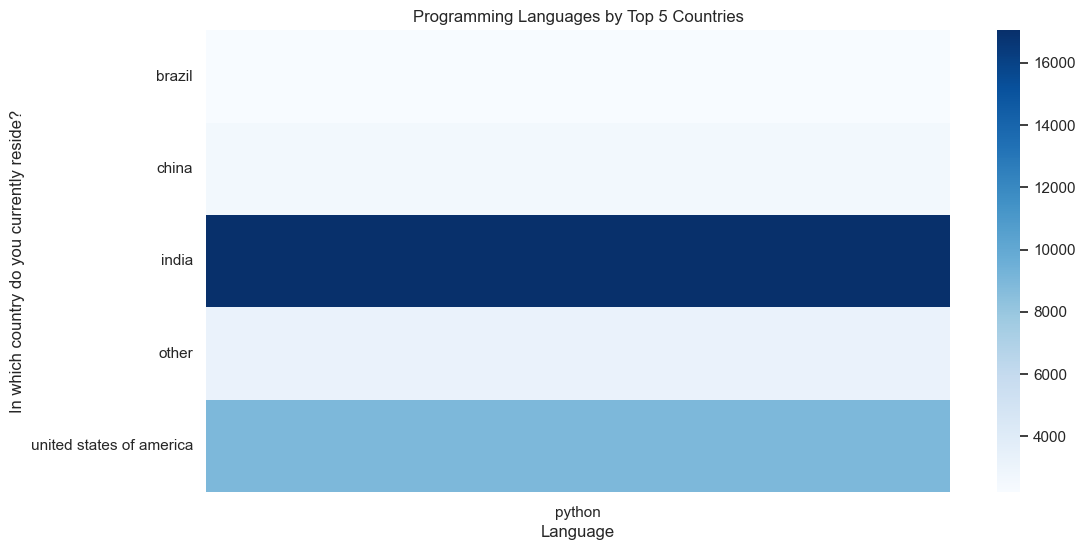

In [6]:
# Top 5 countries by respondent count
top_countries = df["In which country do you currently reside?"].value_counts().head(5).index

# Filter to those countries
df_lang_country = df_languages[df_languages["In which country do you currently reside?"].isin(top_countries)]

# Count languages by country
lang_by_country = (df_lang_country
                   .groupby(["In which country do you currently reside?", "Language"])
                   .size()
                   .reset_index(name="Count"))

# For each country, get top language
top_lang_by_country = lang_by_country.loc[lang_by_country.groupby("In which country do you currently reside?")["Count"].idxmax()]

print("Top language by country:")
print(top_lang_by_country)

# Visualization (heatmap of languages vs countries)
pivot = lang_by_country.pivot(index="In which country do you currently reside?", 
                              columns="Language", 
                              values="Count").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Blues", cbar=True)
plt.title("Programming Languages by Top 5 Countries")
plt.show()


### Top Programming Languages by Country
The heatmap and table highlight the distribution of languages in the top 5 respondent countries.  

- **Python** dominates across all major countries (India, USA, UK, etc.), confirming its global relevance.  
- Secondary languages (R, SQL, C++) vary slightly in popularity by region.  
- For example, R has relatively stronger representation in academic-heavy countries, while SQL is more consistent across industry-driven respondents.  

This global spread underscores Python’s importance for anyone pursuing a data-related career.  


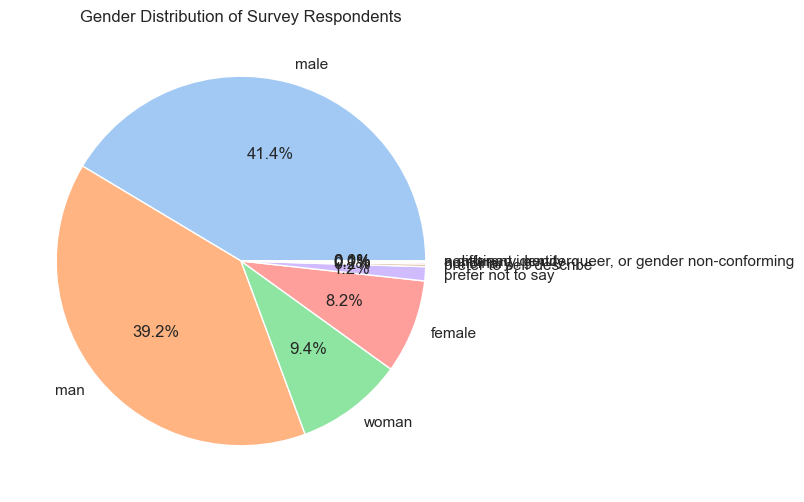

In [7]:
# Gender distribution
plt.figure(figsize=(6,6))
df["What is your gender? - Selected Choice"].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Gender Distribution of Survey Respondents")
plt.ylabel("")
plt.show()


Gender Distribution in Data Science

**Visual:** Pie chart of gender counts.  
**Insight:** Shows the balance (or imbalance) in male vs female participation globally.  


In [8]:
plt.figure(figsize=(10,6))
sns.barplot(y=top_countries.index, x=top_countries.values, color="skyblue")  # fixed
plt.title("Top 10 Countries by Survey Respondents")
plt.xlabel("Number of Respondents")
plt.ylabel("Country")
plt.show()

AttributeError: 'Index' object has no attribute 'index'

<Figure size 1000x600 with 0 Axes>

Top Countries by Respondents

**Visual:** Horizontal bar plot of top 10 countries.  
**Insight:** Identifies which countries dominate participation (India, USA, etc.).  



In [ ]:
# Focus on top roles
top_roles = df["Role_Clean"].value_counts().head(5).index
df_roles = df[df["Role_Clean"].isin(top_roles)]

# Extract language columns
lang_cols = [col for col in df.columns if "What programming languages do you use" in col]

# Count languages by role
lang_by_role = {}
for role in top_roles:
    subset = df_roles[df_roles["Role_Clean"] == role][lang_cols]
    counts = subset.apply(lambda x: x.notna().sum()).sort_values(ascending=False).head(3)
    lang_by_role[role] = counts

lang_df = pd.DataFrame(lang_by_role).fillna(0)

# Plot
lang_df.plot(kind="bar", figsize=(10,6))
plt.title("Top 3 Programming Languages by Role")
plt.ylabel("Number of Mentions")
plt.xlabel("Programming Languages")
plt.xticks(rotation=45)
plt.legend(title="Role")
plt.show()


Programming Languages by Role
    
**Visual:** Grouped bar chart of top 3 languages (Python, R, SQL) used by top 5 roles.  
**Insight:** Highlights how language preferences vary by role (e.g., Analysts rely on SQL, Researchers prefer R, Engineers use Python heavily).  


In [ ]:
# Top education categories
top_edu = df["What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"].value_counts().head(4).index

df_edu_role = df[df["Role_Clean"].notna() & df["What is the highest level of formal education that you have attained or plan to attain within the next 2 years?"].isin(top_edu)]

plt.figure(figsize=(12,6))
sns.countplot(
    data=df_edu_role,
    x="Role_Clean",
    hue="What is the highest level of formal education that you have attained or plan to attain within the next 2 years?",
    order=df_edu_role["Role_Clean"].value_counts().index[:6]  # focus on top roles
)
plt.title("Education vs Role Distribution")
plt.xlabel("Role")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Education Level")
plt.show()


Education vs Role
    
**Visual:** Grouped bar plot showing role counts split by top 4 education levels.  
**Insight:** Shows which education levels align with certain roles (Doctorates → Researchers, Bachelors → Analysts/Engineers).

In [ ]:
trend = df.groupby("Year").size()
plt.figure(figsize=(8,5))
sns.lineplot(x=trend.index, y=trend.values, marker="o", linewidth=2)
plt.title("Survey Participation Trend (2017–2021)")
plt.xlabel("Year")
plt.ylabel("Number of Respondents")
plt.show()


Yearly Trends (2017–2021)

**Visual:** Line plot of respondents per year.  
**Insight:** Shows growth in community engagement over time.  
